In [1]:
%matplotlib widget

In [2]:
import sys
sys.path.append('../..')
from lcs import SRC_ROOT
import json
from pathlib import Path
import matplotlib.pyplot as plt
import jax
import numpy as np
from lcs.configs import Config
from run_script import get_data
from lcs import TEXTWIDTH, PAGEHEIGHT
from lcs.plotting_utils import *
import copy

In [18]:
def plot_loss_wlegend(ax, tape, cfg, label, skip=1, gauss_reduce=True, **largs):
    tape = jax.tree.map(lambda x: x[None], tape) if tape.t.ndim == 1 else tape
    fill_between(ax, tape.t.mean(0), tape.loss, label=label, **(dict(color="k", alpha=1.) | largs), gauss_reduce=gauss_reduce)
    ax.set_ylabel(r"loss $\mathcal{L}$")
    ax.set_yticks([0, .5, 1])
    ax.dataLim.y0 = 0.
    ax.dataLim.y1 = 1.1
    ax.autoscale_view()

In [3]:
comp_cfg = Config(input_size=20,
       output_size=6,
       num_seeds=10, 
       num_contexts=3,
       num_paths=3,
       batch_size=200,
       initialization_scale=0.01,
       regularization_strength=0.3,
       num_layers=1,
       hidden_size=6,
       context_model=True,
       name='comp_L1',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 5.)],
       shared_teachers=True,
       shared_concat_teachers=False,
       c_gt_curriculum="A_B_C__AB_BC_CA__",
       Y_tgt=None,
       W_teachers='generate',
       use_X=True,
       metric='cosine',
       teacher_mode='orthogonal',
       num_blocks=30,
       t_tot=30,
       T_tot=1000,
       block_duration=1.0,
       W_lr=None,
       W1_lr=None,
       W2_lr=None,
       c_lr=None,
       W_tau=0.2, 
       W1_tau=None,
       W2_tau=None,
       c_tau=0.03, 
       dt=0.001,
       log_every=1,
       T_tape=10000, 
       dt_tape=0.001,
       control='',
       data_out_dir='data_internal/generalization/',
       results_out_dir='results_internal/generalization/',
       num_shared_contexts=0,
       mixing_factor=0.5,
       W_regularization_strength=0.0,
       turn_off_regularization=False,
       log_aux=False,
        )
comp_tape, comp_args = get_data(comp_cfg)

In [ ]:
forget_comp_cfg = copy.deepcopy(comp_cfg)
forget_comp_cfg.regularization_strength = 0
forget_comp_cfg.name = 'forget_comp_L1'
forget_comp_tape, forget_comp_args = get_data(forget_comp_cfg)

In [5]:
conc_cfg = Config(input_size=20,
       output_size=6,
       num_seeds=10, 
       num_contexts=3,
       num_paths=3,
       batch_size=200,
       initialization_scale=0.01,
       regularization_strength=0.025, 
       num_layers=1,
       hidden_size=6,
       context_model=False,
       name='conc_L2',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L2', 10.)], 
       shared_teachers=None,
       shared_concat_teachers=True,
       c_gt_curriculum="A_B_C__AB_BC_CA__",
       Y_tgt=None,
       W_teachers='generate',
       use_X=True,
       metric='cosine',
       teacher_mode='orthogonal',
       num_blocks=30,
       t_tot=30,
       T_tot=1000,
       block_duration=1.0,
       W_lr=None,
       W1_lr=None,
       W2_lr=None,
       c_lr=None,
       W_tau=0.2, 
       W1_tau=None,
       W2_tau=None,
       c_tau=0.005, 
       dt=0.01,
       log_every=1,
       T_tape=1000, 
       dt_tape=0.01,
       control='N_diag_mono',
       data_out_dir='data_internal/generalization/',
       results_out_dir='results_internal/generalization/',
       num_shared_contexts=0,
       mixing_factor=0.5,
       W_regularization_strength=0.0,
       turn_off_regularization=False,
       log_aux=False,
        )
conc_tape, conc_args = get_data(conc_cfg)

[WARNING] [2024-09-18 15:51:03,215] in lcs.configs: Using a dt > 1e-3 introduces finite-size effects!


In [ ]:
forget_conc_cfg = copy.deepcopy(conc_cfg)
forget_conc_cfg.regularization_strength = 0
forget_conc_cfg.name = 'forget_conc_L2'
forget_conc_tape, forget_conc_args = get_data(forget_conc_cfg)

In [26]:
s = 2
fig = plt.figure(figsize=(s*TEXTWIDTH, s*PAGEHEIGHT*0.2), layout='constrained')

mosaic = """
ceg
dfh
"""

axd = fig.subplot_mosaic(mosaic)

ax_loss = axd['c']
ax_c = axd['e']
ax_cossim = axd['g']

In [27]:
arg_set = []

ax_loss = axd['c']
ax_c = axd['e']
ax_cossim = axd['g']

ax = ax_loss
plot_loss_wlegend(ax, comp_tape, comp_args, 'flexible')
plot_loss_wlegend(ax, forget_comp_tape, forget_comp_args, 'forgetful', color="tab:grey", zorder=-1)
ax.set_yticks([0, 0.5, 1])
ax.dataLim.y0 = 0.
ax.dataLim.y1 = 1.1
ax.autoscale_view()
ax.legend()

ax = ax_c
plot_c(ax, comp_tape, comp_args,)
ax.set_yticks([0, 0.5, 1])
ax.dataLim.y0 = 0.
ax.dataLim.y1 = 1.1
ax.autoscale_view()

ax = ax_cossim
plot_similarity(ax, comp_tape, comp_args,)

ax_loss.set_ylabel(r'loss $\mathcal{L}$')
ax_c.set_ylabel(r'gates $c^p$')
ax_cossim.set_ylabel('student-teacher' + '\n' + 'alignment ' + r'$\langle \boldsymbol{W}^{m\star} \boldsymbol{W}^{p T}\rangle$')

arg_set.append(comp_args)

ax_loss = axd['d']
ax_c = axd['f']
ax_cossim = axd['h']

ax = ax_loss
plot_loss_wlegend(ax, conc_tape, conc_args, 'flexible')
plot_loss_wlegend(ax, forget_conc_tape, forget_conc_args, 'forgetful', color="tab:grey", zorder=-1)
ax.set_yticks([0, 0.5, 1])
ax.dataLim.y0 = 0.
ax.dataLim.y1 = 1.1
ax.autoscale_view()

ax = ax_c
plot_c(ax, conc_tape, conc_args,)
ax.set_yticks([0, 0.5, 1])
ax.dataLim.y0 = -0.1
ax.dataLim.y1 = 1.3
ax.autoscale_view()

ax = ax_cossim
plot_similarity(ax, conc_tape, conc_args,)

ax_loss.set_ylabel(r'loss $\mathcal{L}$')
ax_c.set_ylabel(r'gates $c^p$')
ax_cossim.set_ylabel('student-teacher' + '\n' + 'alignment ' + r'$\langle \boldsymbol{W}^{m\star} \boldsymbol{W}^{p T}\rangle$')

ax_loss.set_xlabel(r'time $t$')
ax_c.set_xlabel(r'time $t$')
ax_cossim.set_xlabel(r'time $t$')

arg_set.append(conc_args)

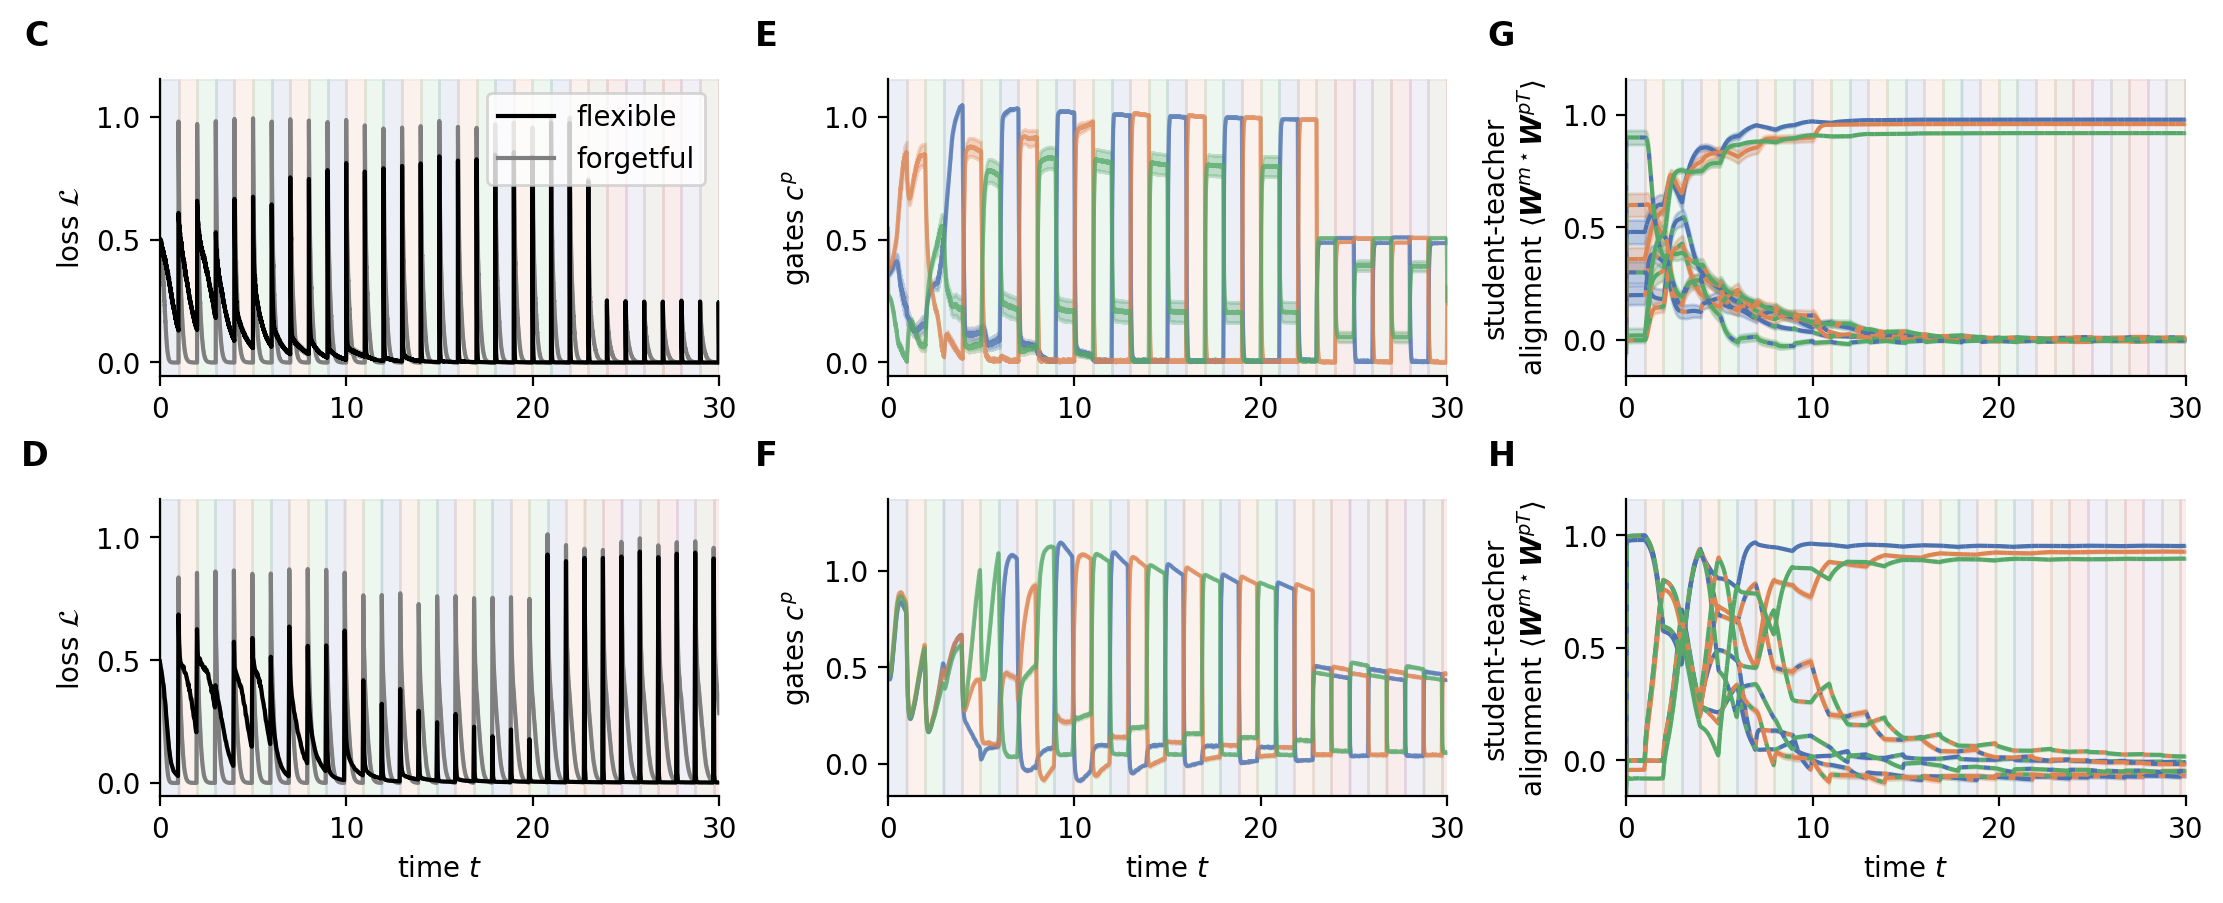

In [28]:
setup_axes_labels(axd)
for k, ax in axd.items():
    if k == 'c' or k== 'e' or k== 'g':
        indicate_contexts_old(ax, comp_tape, arg_set[0])
    if k == 'd' or k== 'f' or k== 'h':
        indicate_contexts_old(ax, conc_tape, arg_set[1])
    ax.set_xlim(0, comp_tape.t.max())
    ax.set_xticks([0, 10, 20, 30])

fig